This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es)

In this notebook we will analyze feature selection and PCA techniques in toy examples for understand their fundamentals.

## Table of Contents

1. [Feature Selection](#feature_selection)
 1. [Filter methods](#filter_methods)
    1. [Regression](#filter_regression)
    2. [Classification](#filter_classification)
 2. [Wrapper methods](#wrapper_methods)  
2. [Feature extraction / dimensionality reduction](#feature_extraction)
 1. [PCA](#pca)
3. [Assignment Lab 5](#assignment)

---
## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
<a id='feature_selection'></a>
# 1. Feature Selection

The aim of feature selection is to select the optimum subset of features/variables in order to reduce the dimensionality of the dataset (and thus mitigating the potential overfitting) and improve interpretability.

<a id='filter_methods'></a>
## 1.A Filter methods 

Filter methods rank the input features according to a predefined relevance score. The following are examples of filters for regression and classification problems

<a id='filter_regression'></a>
### Regression problems

Let's analyze [filter methods]((https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)) for regression ([f_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression), [mutual_info_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)) using a simple example:

<div class="alert alert-block alert-info">
<b>Example 1</b>

Let $x_1, x_2,x_3$ be random variables uniformly distributed within the interval $[0,1]$. Target variable $y$ depends on these variables, as follows

$$y = x_1 + \sin{(6\pi x_2)} + 0.1\mathcal{N}(0, 1),$$

Specifically:

* $y$ depends linearly on $x_1$
* $y$ non linear dependency on $x_2$
* $y$ does not depend on $x_3$

therefore, $x_3$ is **irrelevant** for $y$. 

*Note: this example extracted from [here](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)*
</div>

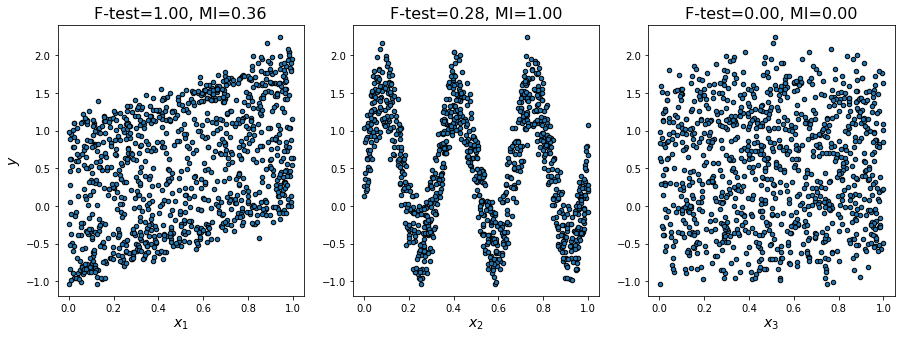

In [2]:
from src.filter_methods import example_one

x1, x2, x3, y = example_one()

<a id='filter_classification'></a>
### Classification problems

Let's define the following classification problems:

<div class="alert alert-block alert-info">
<b>Example 2</b>: linearly separable problem.
    
Let $\{\mathbf{x}_1, \mathbf{x}_2,\ldots, \mathbf{x}_5\}$ be a set of random variables, such that
    
- $\mathbf{x}_1 = z+ \mathcal{N}(0,\sigma_1), \quad z \in \{-\mu,+\mu\}$ 
- $\mathbf{x}_2 = -3\mathbf{x}_1 + \mathcal{N}(0,\sigma_2)$
- $\mathbf{x}_3 = \mathcal{N}(0,2)$
- $\mathbf{x}_4 = \mathcal{U}(0,1)$
        
</div>

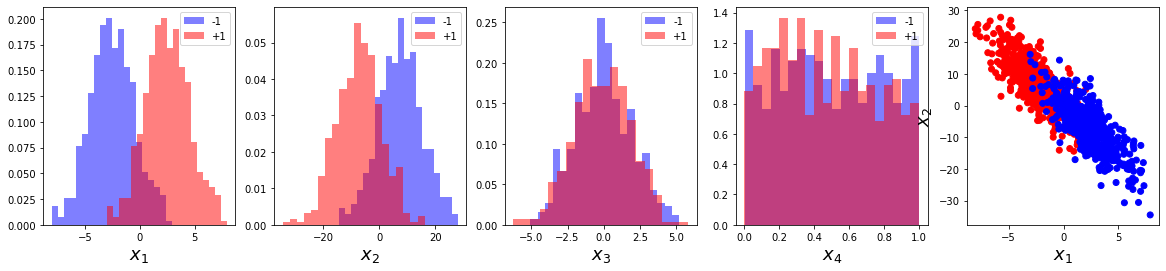

In [3]:
from src.filter_methods import example_two

X, y = example_two(mu = 2.5, sigma_1 = 2, sigma_2 = 5)

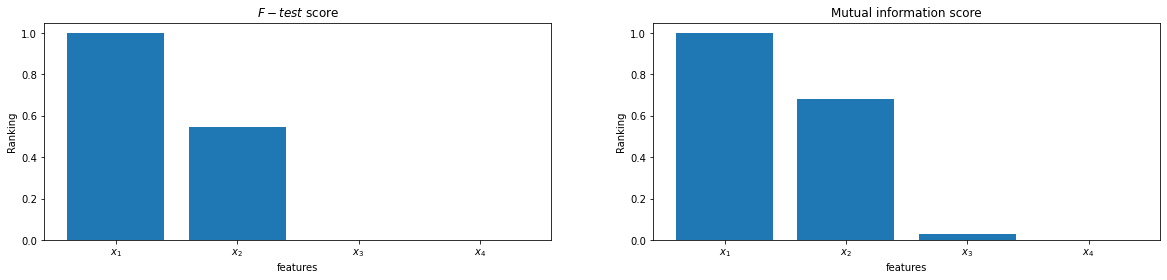

In [4]:
from src.filter_methods import filter_methods_classification

filter_methods_classification(X, y, feat_names = ['$x_1$','$x_2$','$x_3$','$x_4$'])

<div class="alert alert-block alert-info">
<b>Example 3</b>: Non-linear separable problem.
    
Let $\{\mathbf{x}_1, \mathbf{x}_2,\ldots, \mathbf{x}_{24}\}$ be a set of random variables, such that
    
- $\mathbf{x}_1$ and $\mathbf{x}_2$ define an XOR classification problem 
- $\mathbf{x}_3 = 3(\mathbf{x}_1+\mathbf{x}_2)+ \mathcal{N}(0,2)$
- $\mathbf{x}_4 = 2\sqrt{\mathbf{x}_1+\mathbf{x}_2} + \mathcal{N}(0,2)$
- $\mathbf{x}_i = \mathcal{N}(0,4),\quad\forall i=5,\ldots,20$    
    
</div>

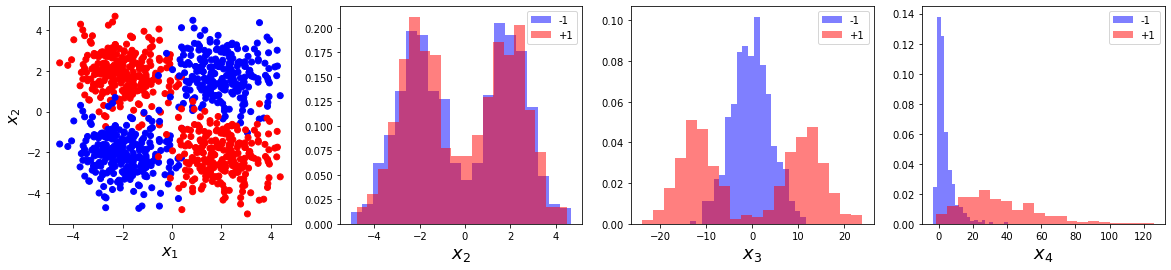

In [5]:
from src.filter_methods import example_three

X, y = example_three(mu=2, sigma=1)

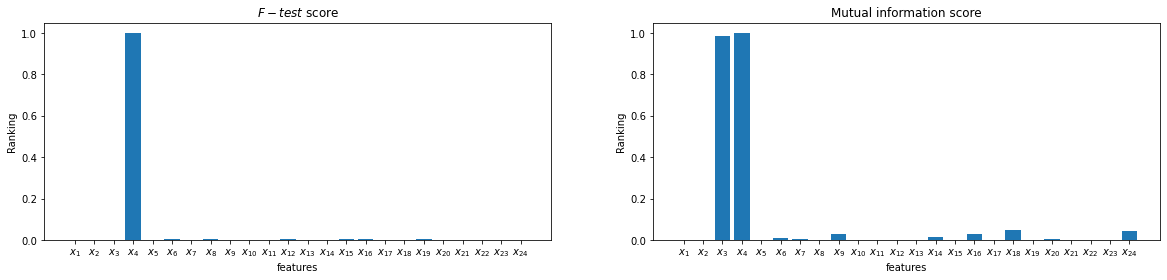

In [6]:
feat_names = ['$x_{'+ str(i+1) + '}$' for i in range(24)]
filter_methods_classification(X, y, feat_names = feat_names)

<div class="alert alert-block alert-info">
<b>Example 4</b>: Real classification problem

Apply filter methods to Pima Indian Diabetes dataset
    
</div>

In [7]:
from src.ddbb import load_pima_indian
X, y = load_pima_indian('./data/pima_indian_diabetes.csv')

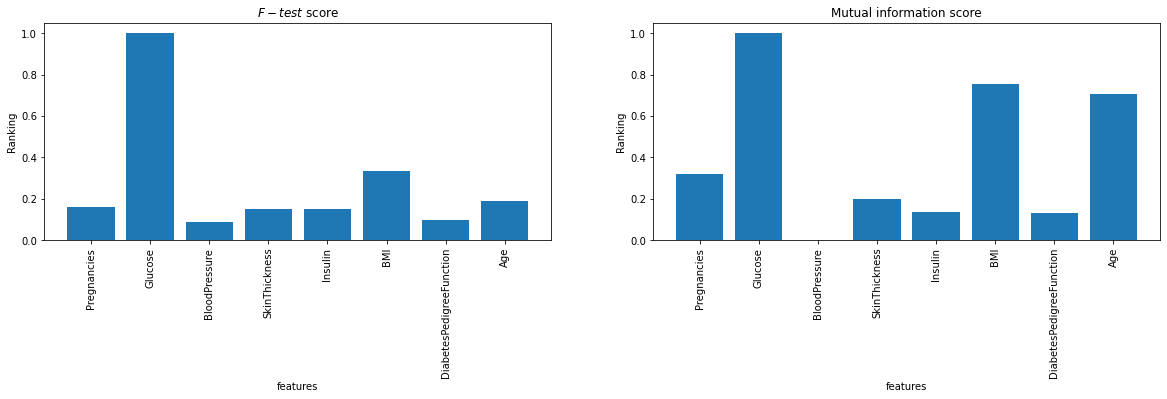

In [8]:
filter_methods_classification(X.values, y.values, feat_names = X.columns, rotation=True)

Now, let's fit a KNN algorithm on a selection of features ... ok, but do it well!!

### An extended feature selection method among practitioners

Could be considered also as an *embbeded* technique.

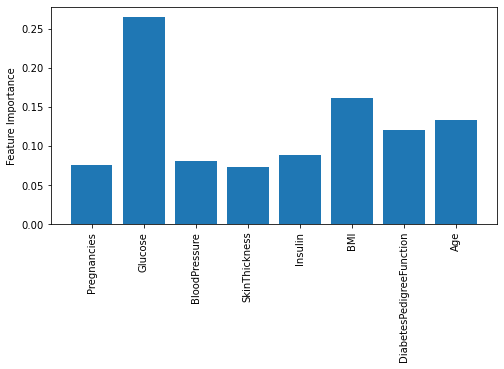

Index(['Glucose', 'BMI'], dtype='object')

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, y)

plt.figure(figsize=(8,4))
plt.bar(range(X.shape[1]),clf.feature_importances_,  align="center")
plt.xticks(range(X.shape[1]),X.columns, rotation = 90)
plt.ylabel('Feature Importance')
plt.show()

# do it automatically
sel = SelectFromModel(clf, threshold=0.15).fit(X,y)
X.columns[sel.get_support()]

<a id='wrapper_methods'></a>
## 1.B Wrapper methods

Wrappers utilize a machine learning algorithm of interest as a **black box** to score subsets of variables according to their predictive power. When estimating the number of selected features the normally use **backward/forward** procedures together with **cross-validation** techniques to assess the performance of each subset. 

### The wrong and right way to do cross-validation

This example, based on section *7.10.2 The Wrong and Right Way to Do Cross-validation* from the book
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

Error rate (%): 3.5719999999999974


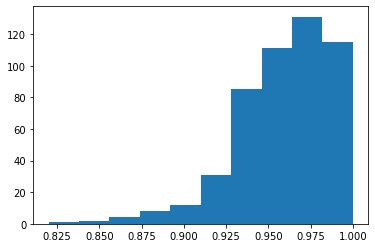

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

# This is the WRONG way
np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments: Montecarlo simulation
    
    # Create toy example: N x D = 50 x 500 !
    N = 50
    X = np.random.randn(N, 5000) # predictors are random variables!!
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    
    # Note here, the ranking and selection is performed outside the CV loop
    # therefore, the selection used all samples, but should use only train samples
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(Xs):
        knn.fit(Xs[train],y[train])
        accuracy = knn.score(Xs[validation],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

Error rate (%): 52.664


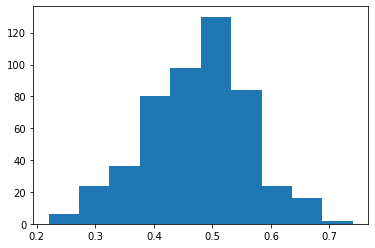

In [11]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(X):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

<div class="alert alert-block alert-info">
<b>Example 5</b>: Backward feature selection 

Implement a backward feature selection algorithm to determine the optimum number of features to address the Pima Indian Diabetes classification problem
    
</div>

You will need:

1. A classification algorithm:
    1. Decision tree with `max_depth=3`
2. A ranking criterion:
    1. `f_classif`
    2. `feature_importance` from the trained decision tree

In [12]:
from src.ddbb import load_pima_indian
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = load_pima_indian('./data/pima_indian_diabetes.csv')
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, random_state=2)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Train data shape: (537, 8)
Test  data shape: (231, 8)


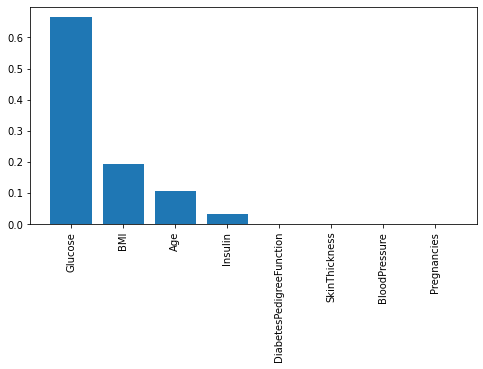

In [13]:
from sklearn.tree import DecisionTreeClassifier

# train a tree
dt = DecisionTreeClassifier(max_depth=3, random_state=2).fit(X_train_scaled,y_train)

# get the importance
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

# do the plotting
plt.figure(figsize=(8, 4))
plt.bar(range(X_train_scaled.shape[1]), importances[indices],align="center")
plt.xticks(range(X_train_scaled.shape[1]),feat_names[indices], rotation=90)
plt.show()

# features 1 error 0.37232606438213917 +/- 0.029693410969644233
# features 2 error 0.36860505365178264 +/- 0.02770473883640756
# features 3 error 0.379785392869505 +/- 0.02631364794507943
# features 4 error 0.36675320179993076 +/- 0.02903995300742885
# features 5 error 0.36114572516441684 +/- 0.030977141092773535
# features 6 error 0.35927656628591215 +/- 0.03210835482144442
# features 7 error 0.36114572516441684 +/- 0.030977141092773535
# features 8 error 0.3648840429214261 +/- 0.029423961000323365


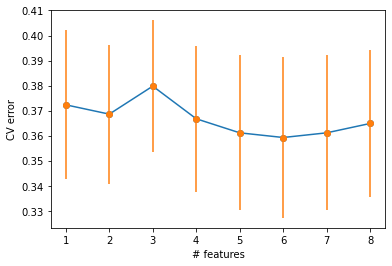

In [14]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

N, D = X_train_scaled.shape

dt = DecisionTreeClassifier(max_depth=3, random_state=2)
kf = KFold(n_splits=5, shuffle = True, random_state=2)

cv_error = []
cv_std = []

for n in range(D,0,-1):
        
    error_i = []
    
    for train, validation in kf.split(X_train_scaled):
        
        #-- ranking: two options
        
        # option 1: f-test
        f_test, _ = f_classif(X_train_scaled[train], y_train[train])
        f_test /= np.max(f_test)   
        ranking = np.argsort(f_test)[::-1] 
        
        # option 2: feature importance
        ranking = dt.fit(X_train_scaled[train],y_train[train]).feature_importances_
        
        #-- selection
        indices = np.argsort(ranking)[::-1] 
        selected = indices[0:(D-n+1)]
        Xs = X_train_scaled[:,selected]
        
        #-- fit on selected features
        dt.fit(Xs[train],y[train])
        error = 1.0 - dt.score(Xs[validation],y[validation])
        error_i.append(error) 
        
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

plt.plot(range(1,D+1,1),cv_error,'-o')
plt.errorbar(range(1,D+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

In [15]:
# complete dataset
dt.fit(X_train_scaled,y_train)
print('Completed model score: ' + str(dt.score(X_test_scaled, y_test)))

# fit reduce dataset
selection = 1 # Glucose
dt.fit(X_train_scaled[:,selection].reshape(-1, 1),y_train)
print('Reduced model score: ' + str(dt.score(X_test_scaled[:,selection].reshape(-1, 1), y_test)))

Completed model score: 0.7532467532467533
Reduced model score: 0.7316017316017316


### Other methods for forward/backward feature selection

- Recursive Feature Elimination ([original paper](http://clopinet.com/isabelle/Papers/geneselect.pdf)): select features by recursively considering smaller and smaller sets of features based on `coef_` or `feature_importances_` attributes. In scikit-learn:
    * [feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)
    * [feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)
    
- [Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/), by [mlextend](http://rasbt.github.io/mlxtend/). 

---
<a id='feature_extraction'></a>
# 2. Feature Extraction / dimensionality reduction

We will be working with the life expectancy dataset

In [16]:
from src.ddbb import load_life_expectancy

X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

Predictors:  (2938, 211)
Target:  (2938,)


<a id='pca'></a>
## 2.1 PCA

Let's start first with an easy example

*Note: this example was extracted from [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html). I encourage you to take a depth look at this notebook for understading PCA*

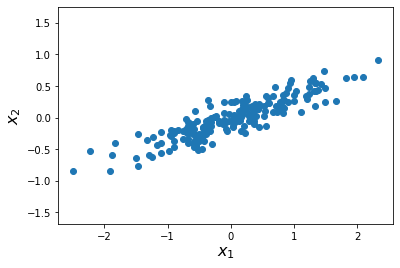

In [17]:
from src.pca_utils import toy_example_pca

X = toy_example_pca()

Recall that PCA transforms (linearly) the original space into a an orthonormal basis (principal components) in which different individual dimensions of the data are linearly uncorrelated:
 - [Principal components](https://en.wikipedia.org/wiki/Principal_component_analysis#Quantitative_finance) are a sequence of direction vectors, where the $i^{{\text{th}}}$ vector is the direction of a line that best fits the data while being orthogonal to the first  $i-1$ vectors
 - Principal components are eigenvectors of the data's covariance matrix

Components:
 [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
Variance of each axis (largest eigenvalues): [0.7625315 0.0184779]


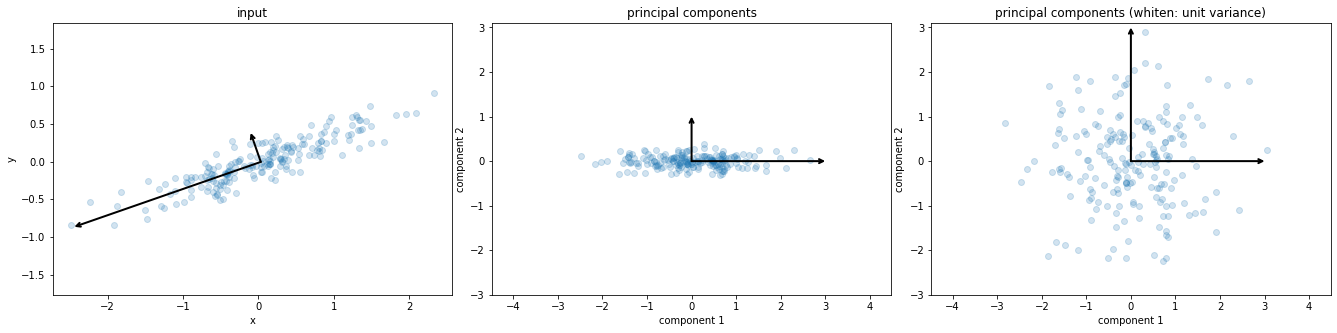

In [18]:
from src.pca_utils import plot_pca_toy_example

pca = plot_pca_toy_example(X)

print('Components:\n', pca.components_)
print('Variance of each axis (largest eigenvalues):', pca.explained_variance_)

### PCA for dimensionality reduction

Project our 2D data into 1D

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(X)
X_pca = pca.transform(X) # this X is on the transformed space ...

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


To see the transformed data in the original space

This transformation retains the 97.63% of the variance


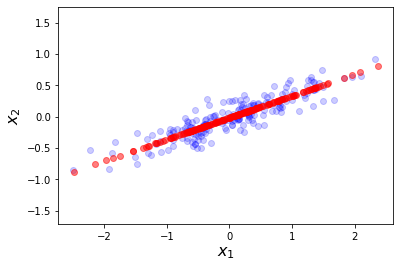

In [20]:
X_new = pca.inverse_transform(X_pca)

plt.scatter(X[:, 0], X[:, 1], c = 'b', alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], c='r', alpha=0.5)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.axis('equal');

print('This transformation retains the {:.2f}% of the variance'.format(100*pca.explained_variance_ratio_[0]))

<div class="alert alert-block alert-info">
<b>Example 6</b>: Apply PCA to life expectancy data

- How many components do we need? 
- Visualize your data
- Train a ML model using the transformed features
</div>

Predictors:  (2938, 211)
Target:  (2938,)


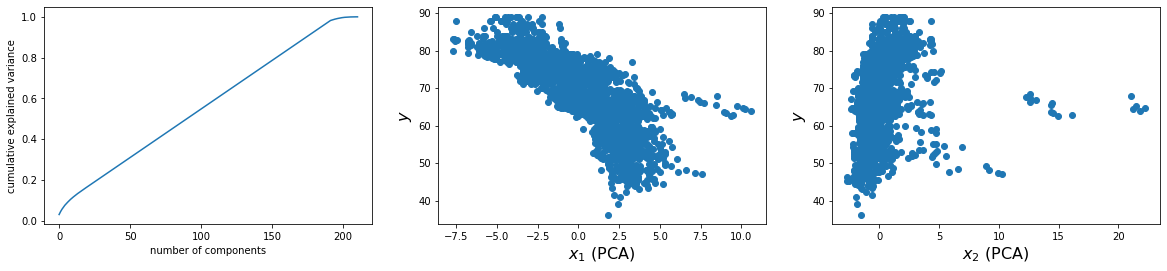

In [21]:
from src.ddbb import load_life_expectancy

X, y = load_life_expectancy('./data/Life Expectancy Data.csv')

# scaling
X_scaled = StandardScaler().fit_transform(X)

# Number of components
pca = PCA().fit(X_scaled)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Data visualization (just 2 components)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.subplot(1,3,2)
plt.scatter(X_pca[:,0],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(1,3,3)
plt.scatter(X_pca[:,1],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.show()

Even if these two variables look like promising, **do they provide with any interpretation about the data?** You might find of interest the following:

- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
- [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/) (deep learning)

In [22]:
# Just a quick view, not a proper training
from sklearn.linear_model import LinearRegression

# fit a linear regression model
lr =  LinearRegression().fit(X_pca, y)
print('Train R2 score: {:.3f}'.format(lr.score(X_pca, y)))

Train R2 score: 0.688


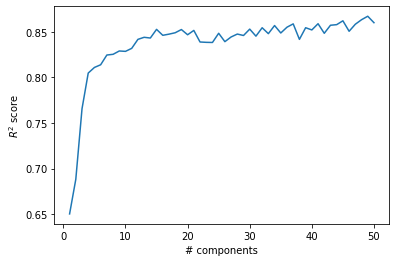

In [23]:
# Just a quick view, not a proper training
r2_score = [] 
n_components_max = 50
for i in range(n_components_max):
    X_pca = PCA(n_components=i+1).fit_transform(X_scaled)
    lr =  LinearRegression().fit(X_pca, y)
    r2_score.append(lr.score(X_pca, y))

plt.plot(np.arange(n_components_max)+1,r2_score)
plt.xlabel('# components')
plt.ylabel('$R^2$ score')
plt.show()

---
<a id='assignment'></a>
# Assignment Lab 5

1. Using filter methods (select the method you want), train a model using the 10 features on the life expectancy data. What is the performance compared to the complete model (using all features)? Justify your answer
2. Using a backward selection procedures, how many features would you use for the life expectancy data? Justify your answer.
3. For the life expectancy data, analyze the model performance using PCA transformed variables as input features for the model. Compare your results using the original features. To do son:
    - Choose a ML model
    - Choose a number of `n_components`
    - Asesss model performance, using a chosen regression metric

In all above, justify your selections.

4. Visualize the PCA transformation (use `n_components=2`) for the Pima Indian database, using a scatter plot. Colour your transformed samples according to the sample label (example [here](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py)). Is this transformation useful for classification? Justify your answer in terms of performance and interpretability.

---
# Data utilized for the lab questions

In [120]:
from src.ddbb import load_life_expectancy, load_pima_indian
X_pi, Y_pi = load_pima_indian('./data/pima_indian_diabetes.csv')
X_le, Y_le = load_life_expectancy('./data/Life_Expectancy_Data.csv')

Predictors:  (2938, 211)
Target:  (2938,)


<span style="background-color: lightblue">QUESTION 1:</span> 

1. Using filter methods (select the method you want), train a model using the 10 features on the life expectancy data. What is the performance compared to the complete model (using all features)? Justify your answer

## <span style="color:darkcyan"> Answer to question 1:  </span>

<span style="background-color: darkcyan">Section 1.1) </span> 

Plotting and checking out the columns of Life expectancy data file. Additionally, we look at the type of X_le and Y_le, in order to know with which kind of data we are going to work with in the following cells.

In [121]:
print(len(X_pi.columns), ',',len(X_le.columns))
for i in X_le.columns:
    print(i)

8 , 211
year
status
adult_mortality
alcohol
percentage_expenditure
hepatitis_b
measles
bmi
under-five_deaths
polio
total_expenditure
diphtheria
hiv/aids
gdp
population
thinness_10-19_years
thinness_5-9_years
income_composition_of_resources
schooling
country_Albania
country_Algeria
country_Angola
country_Antigua and Barbuda
country_Argentina
country_Armenia
country_Australia
country_Austria
country_Azerbaijan
country_Bahamas
country_Bahrain
country_Bangladesh
country_Barbados
country_Belarus
country_Belgium
country_Belize
country_Benin
country_Bhutan
country_Bolivia (Plurinational State of)
country_Bosnia and Herzegovina
country_Botswana
country_Brazil
country_Brunei Darussalam
country_Bulgaria
country_Burkina Faso
country_Burundi
country_Cabo Verde
country_Cambodia
country_Cameroon
country_Canada
country_Central African Republic
country_Chad
country_Chile
country_China
country_Colombia
country_Comoros
country_Congo
country_Cook Islands
country_Costa Rica
country_Croatia
country_Cuba
co

In [122]:
import pandas
pandas.set_option('display.max_columns', None)
X_le.describe()

,year,status,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bhutan,country_Bolivia (Plurinational State of),country_Bosnia and Herzegovina,country_Botswana,country_Brazil,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cabo Verde,country_Cambodia,country_Cameroon,country_Canada,country_Central African Republic,country_Chad,country_Chile,country_China,country_Colombia,country_Comoros,country_Congo,country_Cook Islands,country_Costa Rica,country_Croatia,country_Cuba,country_Cyprus,country_Czechia,country_Côte d'Ivoire,country_Democratic People's Republic of Korea,country_Democratic Republic of the Congo,country_Denmark,country_Djibouti,country_Dominica,country_Dominican Republic,country_Ecuador,country_Egypt,country_El Salvador,country_Equatorial Guinea,country_Eritrea,country_Estonia,country_Ethiopia,country_Fiji,country_Finland,country_France,country_Gabon,country_Gambia,country_Georgia,country_Germany,country_Ghana,country_Greece,country_Grenada,country_Guatemala,country_Guinea,country_Guinea-Bissau,country_Guyana,country_Haiti,country_Honduras,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Iran (Islamic Republic of),country_Iraq,country_Ireland,country_Israel,country_Italy,country_Jamaica,country_Japan,country_Jordan,country_Kazakhstan,country_Kenya,country_Kiribati,country_Kuwait,country_Kyrgyzstan,country_Lao People's Democratic Republic,country_Latvia,country_Lebanon,country_Lesotho,country_Liberia,country_Libya,country_Lithuania,country_Luxembourg,country_Madagascar,country_Malawi,country_Malaysia,country_Maldives,country_Mali,country_Malta,country_Marshall Islands,country_Mauritania,country_Mauritius,country_Mexico,country_Micronesia (Federated States of),country_Monaco,country_Mongolia,country_Montenegro,country_Morocco,country_Mozambique,country_Myanmar,country_Namibia,country_Nauru,country_Nepal,country_Netherlands,country_New Zealand,country_Nicaragua,country_Niger,country_Nigeria,country_Niue,country_Norway,country_Oman,country_Pakistan,country_Palau,country_Panama,country_Papua New Guinea,country_Paraguay,country_Peru,country_Philippines,country_Poland,country_Portugal,country_Qatar,country_Republic of Korea,country_Republic of Moldova,country_Romania,country_Russian Federation,country_Rwanda,country_Saint Kitts and Nevis,country_Saint Lucia,country_Saint Vincent and the Grenadines,country_Samoa,country_San Marino,country_Sao Tome and Principe,country_Saudi Arabia,country_Senegal,country_Serbia,country_Seychelles,country_Sierra Leone,country_Singapore,country_Slovakia,country_Slovenia,country_Solomon Islands,country_Somalia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Suriname,country_Swaziland,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Tajikistan,country_Thailand,country_The former Yugoslav republic of Macedonia,country_Timor-Leste,country_Togo,country_Tonga,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Tuvalu,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom of Great Britain and Northern Ireland,country_United Republic of Tanzania,country_United States of America,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Yemen,country_Zambia,country_Zimbabwe
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00

In [123]:
features = ['adult_mortality', 'bmi' ,'under-five_deaths' ,'diphtheria' ,'hiv/aids' ,'gdp' ,
            'thinness_10-19_years' ,'thinness_5-9_years' ,'income_composition_of_resources', 
                'schooling'] # 10 features from the original

for i in range(0,len(X_le.dtypes)):
    print(X_le.columns[i],X_le.dtypes[i]) # Original features

year int64
status int64
adult_mortality float64
alcohol float64
percentage_expenditure float64
hepatitis_b float64
measles int64
bmi float64
under-five_deaths int64
polio float64
total_expenditure float64
diphtheria float64
hiv/aids float64
gdp float64
population float64
thinness_10-19_years float64
thinness_5-9_years float64
income_composition_of_resources float64
schooling float64
country_Albania uint8
country_Algeria uint8
country_Angola uint8
country_Antigua and Barbuda uint8
country_Argentina uint8
country_Armenia uint8
country_Australia uint8
country_Austria uint8
country_Azerbaijan uint8
country_Bahamas uint8
country_Bahrain uint8
country_Bangladesh uint8
country_Barbados uint8
country_Belarus uint8
country_Belgium uint8
country_Belize uint8
country_Benin uint8
country_Bhutan uint8
country_Bolivia (Plurinational State of) uint8
country_Bosnia and Herzegovina uint8
country_Botswana uint8
country_Brazil uint8
country_Brunei Darussalam uint8
country_Bulgaria uint8
country_Burkina F

In [124]:
from sklearn.feature_selection import mutual_info_regression

In [125]:
Y_le.describe()

count    2938.000000
mean       69.224932
std         9.507640
min        36.300000
25%        63.200000
50%        72.000000
75%        75.600000
max        89.000000
Name: life_expectancy, dtype: float64

In [126]:
print(X_le.shape[1]) # Number of features

211


<span style="background-color: darkcyan">Section 1.2) </span> 

We choose mutual information as our measure technique. Therefore, we will use the mutual information regression technique.

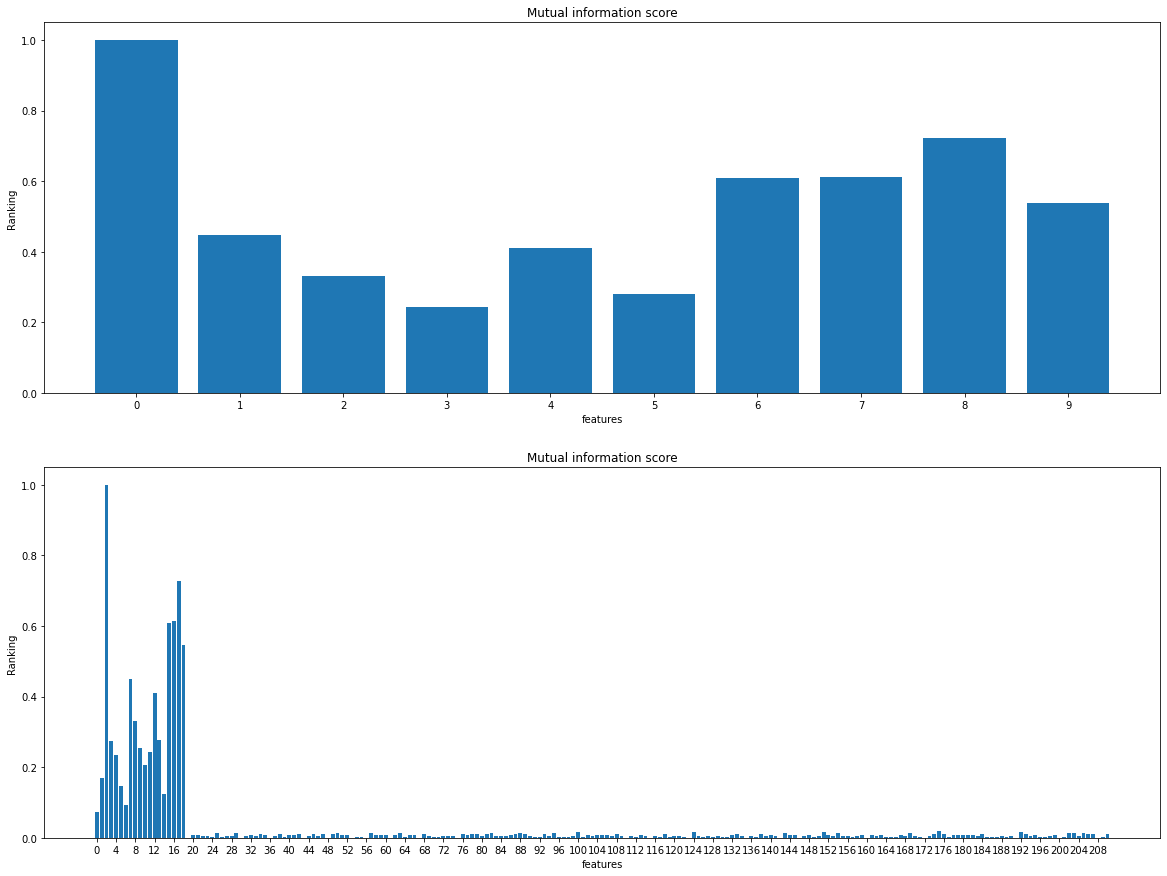

In [127]:
X = X_le[features].values
Y = Y_le.values
mi_rg = mutual_info_regression(X,Y)
mi_rg /= np.max(mi_rg)

X_all = X_le.values
mi_rg_all = mutual_info_regression(X_all,Y)
mi_rg_all /= np.max(mi_rg_all)

plt.figure(figsize=(20, 15))
plt.subplot(2,1,1)
plt.bar(range(X.shape[1]), mi_rg,  align="center")
plt.xticks(range(X.shape[1]),range(len(features)), rotation = 0)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.subplot(2,1,2)
plt.bar(range(X_all.shape[1]), mi_rg_all,  align="center")
plt.xticks(range(0,X_all.shape[1], 4),range(0, len(X_le.columns), 4))
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.tight_layout
plt.show()

<span style="background-color: darkcyan">Section 1.3) </span> 

Finally, we implement a random forest regressor model.

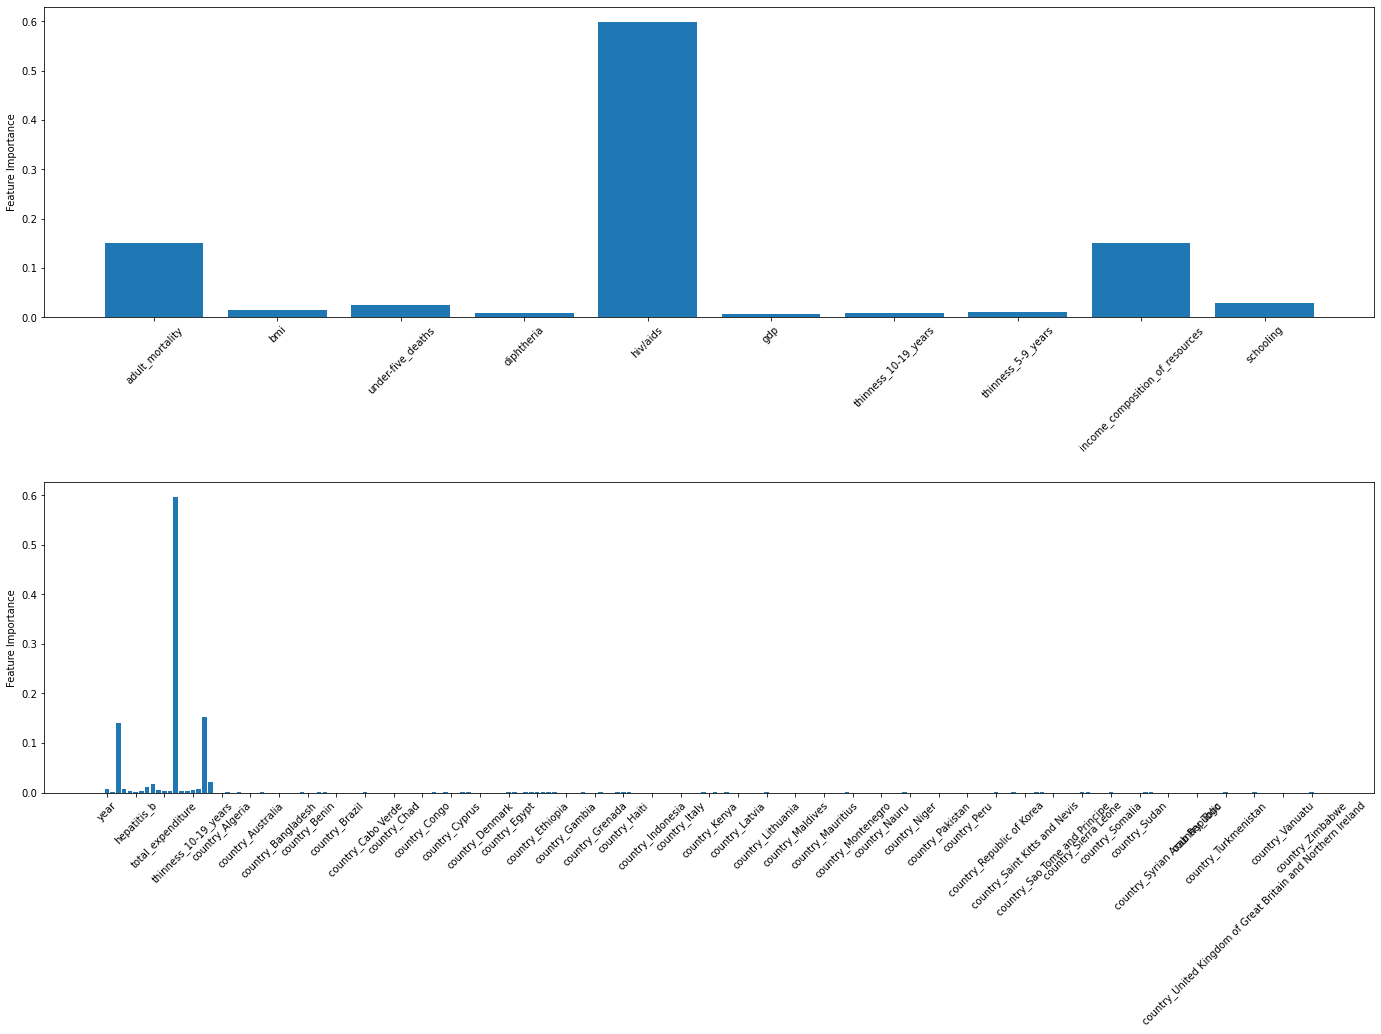

Index(['adult_mortality', 'hiv/aids', 'income_composition_of_resources'], dtype='object')
Index(['adult_mortality', 'hiv/aids', 'income_composition_of_resources'], dtype='object')


In [128]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# model for regresion Random forest
X = X_le[features]

clf = RandomForestRegressor().fit(X, Y_le)
clf_all = RandomForestRegressor().fit(X_le, Y_le)

plt.figure(figsize=(20, 15))
plt.subplot(2,1,1)
plt.bar(range(X.shape[1]),clf.feature_importances_,  align="center")
plt.xticks(range(X.shape[1]),X.columns, rotation = 45)
plt.ylabel('Feature Importance')

plt.subplot(2,1,2)
plt.bar(range(X_le.shape[1]),clf_all.feature_importances_,  align="center")
plt.xticks(range(0,X_le.shape[1],5),X_le.columns[::5], rotation = 45)
plt.ylabel('Feature Importance')

plt.tight_layout(pad=3.0)
plt.show()

sel = SelectFromModel(clf, threshold=0.10).fit(X,Y_le)
print(X.columns[sel.get_support()])
sel = SelectFromModel(clf_all, threshold=0.10).fit(X_le,Y_le)
print(X_le.columns[sel.get_support()])

### Justification of answer 1

After deciding ten features from the original amount of the whole data set, we finally find out that the results from filtering method converge into the same result. The basic difference is most likely the computational time. But, due to the similarity of importance of some specific features, the algorithm gets same conclusion either using X[features] or X_all.

Later, when we try to train the model chosen (Random forest) with both data sets, we obtain the same conclusion as expected. This is explained by the previous filter method. The mutual informasion that we performed gave us the features which provide more significance to the results. 

<span style="background-color: lightblue">QUESTION 2:</span> 

2. Using a backward selection procedures, how many features would you use for the life expectancy data? Justify your answer.

## <span style="color:darkcyan"> Answer to question 2:  </span>

<span style="background-color: darkcyan">Section 2.1) </span> 

First of all, we separate the data given by the life expectancy data file into training and testing test. Next, we standardize the features and check out its corresponding shapes.

In [129]:
from src.ddbb import load_life_expectancy
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')
print(X.columns)

Predictors:  (2938, 211)
Target:  (2938,)
Index(['year', 'status', 'adult_mortality', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi',
       'under-five_deaths', 'polio',
       ...
       'country_United Republic of Tanzania',
       'country_United States of America', 'country_Uruguay',
       'country_Uzbekistan', 'country_Vanuatu',
       'country_Venezuela (Bolivarian Republic of)', 'country_Viet Nam',
       'country_Yemen', 'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=211)


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = X.columns
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

NameError: name 'X' is not defined

In [131]:
print(features)

Index(['year', 'status', 'adult_mortality', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi',
       'under-five_deaths', 'polio',
       ...
       'country_United Republic of Tanzania',
       'country_United States of America', 'country_Uruguay',
       'country_Uzbekistan', 'country_Vanuatu',
       'country_Venezuela (Bolivarian Republic of)', 'country_Viet Nam',
       'country_Yemen', 'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=211)


<span style="background-color: darkcyan">Section 2.2) </span> 

As second step, we train a random forest regressor. Additionally, we evaluate the importance of the features and plot it in order to visually analyze the impurity-based feature importances.

Columns by orders importance:  ['hiv/aids', 'adult_mortality', 'income_composition_of_resources', 'under-five_deaths', 'bmi']


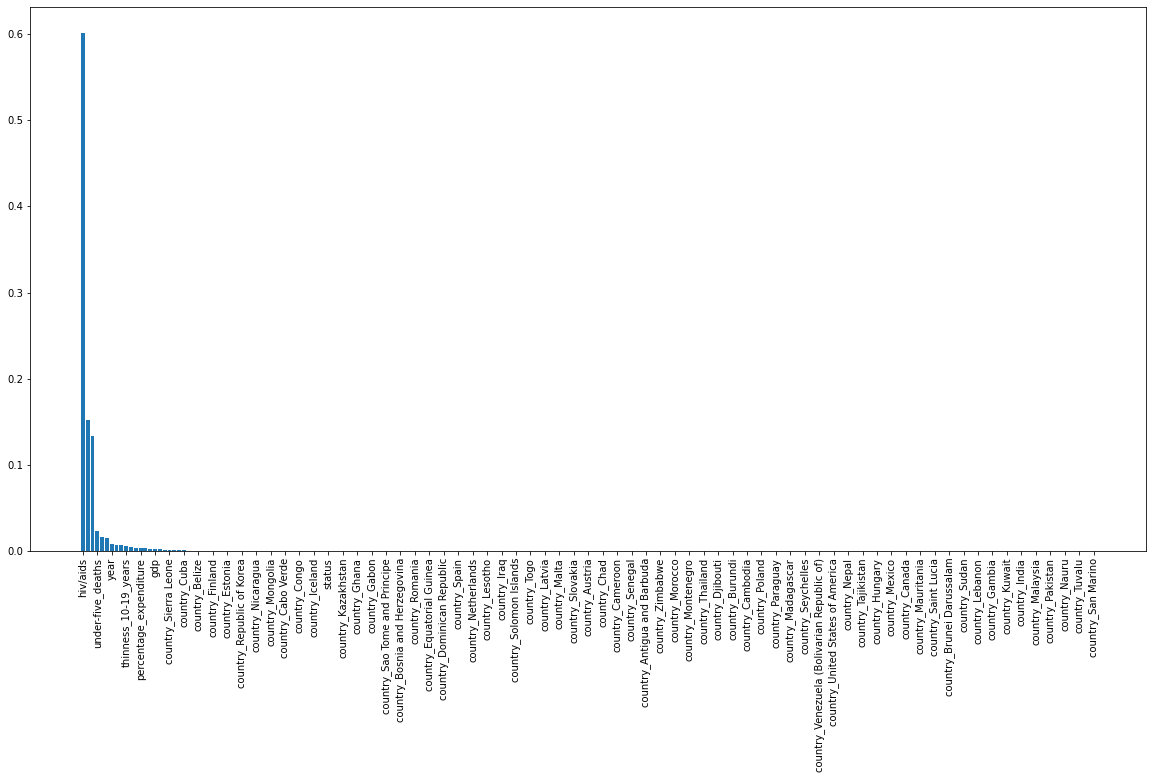

In [134]:
from sklearn.ensemble import RandomForestRegressor
# train random forest
rf = RandomForestRegressor(random_state=0).fit(X_train_scaled,y_train)

# get the importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print('Columns by orders importance: ', [i for i in feat_names[indices][0:5]])

# do the plotting
plt.figure(figsize=(20, 10))
plt.bar(range(X_train_scaled.shape[1]), importances[indices],align="center")
plt.xticks(range(0,X_train_scaled.shape[1],3),feat_names[indices][::3], rotation=90, fontsize = 10)
plt.show()

<span style="background-color: darkcyan">Section 2.3) </span> 

Finally, we study the error variance with respect to the number of features analyzed.

In [70]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression

N, D = X_train_scaled.shape

rf = RandomForestRegressor(random_state=0)
kf = KFold(n_splits=3, shuffle = True, random_state=0)

cv_error = []
cv_std = []
number_features = []

for n in range(D,0,-1): # -2 to reduce by half the time
        
    error_i = []
    
    for train, validation in kf.split(X_train_scaled):
        
        # option 1: mutual_info_regression
        mi_rg = mutual_info_regression(X_train_scaled[train], y_train[train])
        mi_rg /= np.max(mi_rg) 
        ranking = np.argsort(mi_rg)[::-1] 
        
        #-- selection
        indices = np.argsort(ranking)[::-1] 
        selected = indices[0:(D-n+1)] # Important, n = 211 means 1 feature selected . . .Example
        Xs = X_train_scaled[:,selected]
        
        #-- fit on selected features
        rf.fit(Xs[train],y[train])
        error = 1.0 - rf.score(Xs[validation],y[validation])
        error_i.append(error) 
        
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    number_features.append(n)
    
    
   # print('# features ' + str(n) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

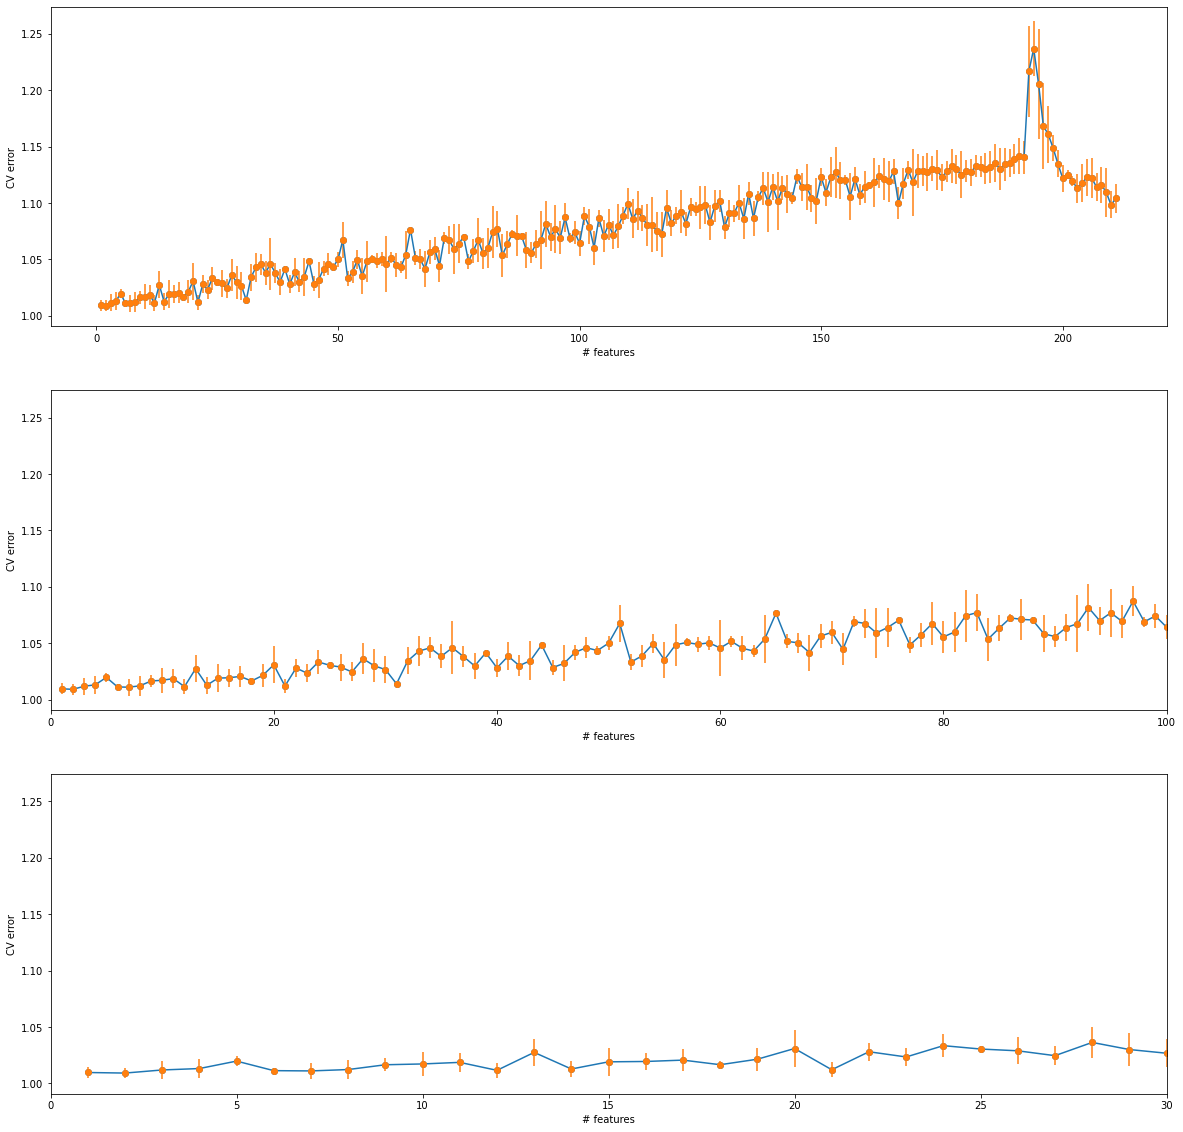

In [81]:
plt.figure(figsize=(20, 20))
plt.subplot(3,1,1)
plt.plot(number_features[::-1],cv_error,'-o')
plt.errorbar(number_features[::-1], cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')

plt.subplot(3,1,2)
plt.plot(number_features[::-1],cv_error,'-o')
plt.errorbar(number_features[::-1], cv_error, yerr=cv_std, fmt='o')
plt.xlim(0,100)
plt.xlabel('# features')
plt.ylabel('CV error')

plt.subplot(3,1,3)
plt.plot(number_features[::-1],cv_error,'-o')
plt.errorbar(number_features[::-1], cv_error, yerr=cv_std, fmt='o')
plt.xlim(0,30)
plt.xlabel('# features')
plt.ylabel('CV error')

plt.show()

In [101]:
print('First 20 features selected')
for i,j in zip(number_features[:185:-1],cv_error[0:25]):
    print(i, ' = ', j)
print('')
print('Minimun error = ',np.min(cv_error[0:25]))
print('')
print('From 200 to 211 features selected')
for i,j in zip(number_features[0:11],cv_error[200:]):
    print(i, ' = ', j)

First 20 features selected
1  =  1.0095859000945264
2  =  1.0090801638488396
3  =  1.0118315180602713
4  =  1.0130923123958728
5  =  1.0196972939725235
6  =  1.0112263577459448
7  =  1.010979800981098
8  =  1.012205460303692
9  =  1.016447849519072
10  =  1.0171658184926262
11  =  1.0185699436378235
12  =  1.0115068901231326
13  =  1.0274179605692704
14  =  1.0126929257041157
15  =  1.0190446725877085
16  =  1.01935829773516
17  =  1.020567300113745
18  =  1.0164886294847844
19  =  1.0213664805243388
20  =  1.0308496872303003
21  =  1.012038591037621
22  =  1.027978361234857
23  =  1.0233609791868359
24  =  1.0333897117487254
25  =  1.0303942746799828

Minimun error =  1.0090801638488396

From 200 to 211 features selected
211  =  1.1253027839080747
210  =  1.1196832892918303
209  =  1.1130376468413101
208  =  1.1176255928608934
207  =  1.1228597990250895
206  =  1.1220764500837577
205  =  1.114298329240061
204  =  1.1162644452440205
203  =  1.1097309029120634
202  =  1.0984019193245491

### Justification of answer 2    

Looking to the last graph of interest, we decide that the most optimal value for the life expectancy data set is 2 features. Here you can observe the results of getting the first twenty features and the last eleven features selected. We observe, that with two features, we get the most minimum error calculated there but we have to be careful with the overfitting scenario (by selecting 2 features, we get a very low number of features)

<span style="background-color: lightblue">QUESTION 3:</span> 

3. For the life expectancy data, analyze the model performance using PCA transformed variables as input features for the model. Compare your results using the original features. To do son:
    - Choose a ML model
    - Choose a number of `n_components`
    - Asesss model performance, using a chosen regression metric

## <span style="color:darkcyan"> Answer to question 3:  </span>

### <span style="color: darkcyan">Section 3.1) </span> 

First of all, we did decide to analyze life expectancy data with a Random Forest Regressor as our machine learning model. Therefore, we evaluate the performance of the model by utilizing PCA transformed variables. Additionally, we studied the cumulative explained variance ratio.

In [2]:
from src.ddbb import load_life_expectancy
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 211)
Test  data shape: (882, 211)


In [143]:
# ML Model = Random forest Regressor
from sklearn.ensemble import RandomForestRegressor
Rf = RandomForestRegressor()

from sklearn.decomposition import PCA
r2_score = [] 
n_components_max = 50
for i in range(n_components_max):
    X_train_pca = PCA(n_components=i+1).fit_transform(X_train_scaled)
    rf =  Rf.fit(X_train_pca, y_train)
    X_test_pca = PCA(n_components=i+1).fit_transform(X_test_scaled)
    r2_score.append(rf.score(X_test_pca, y_test))

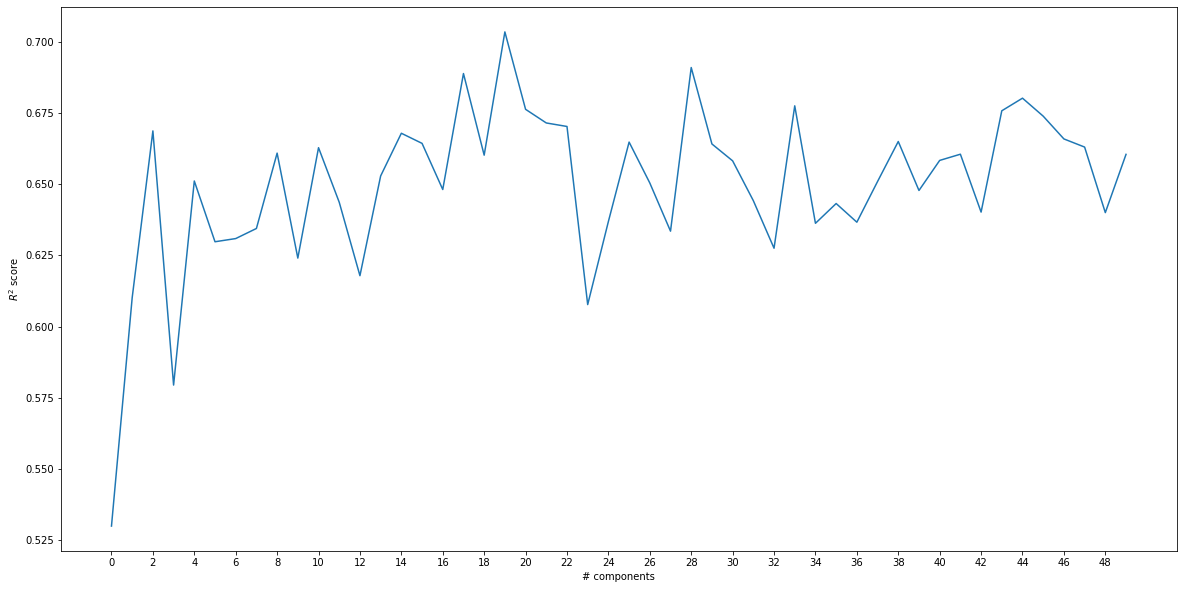

In [153]:
plt.figure(figsize=(20, 10))
plt.plot(range(0,n_components_max),r2_score)
plt.xticks(range(0,n_components_max,2), rotation=0, fontsize = 10)
plt.xlabel('# components')
plt.ylabel('$R^2$ score')
plt.show()

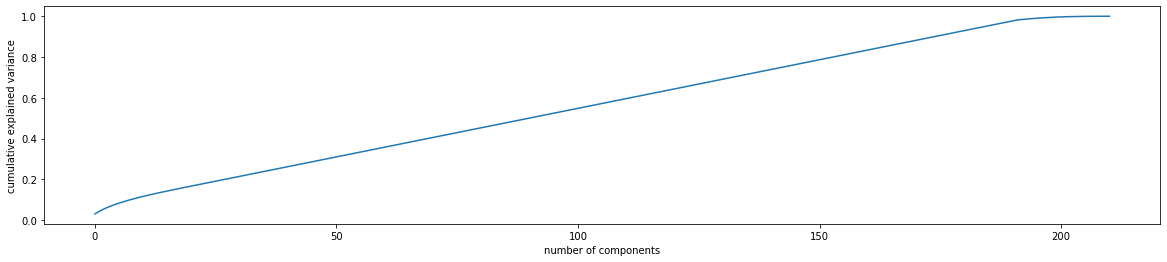

In [168]:
pca = PCA().fit(X_scaled)

plt.figure(figsize=(20,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

plt.show()

### <span style="color: darkcyan">Section 3.2) </span> 

Data visualization of the 19 components (see the following plottings)

In [154]:
from src.ddbb import load_life_expectancy
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')

from sklearn.preprocessing import StandardScaler


# scaling
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Predictors:  (2938, 211)
Target:  (2938,)


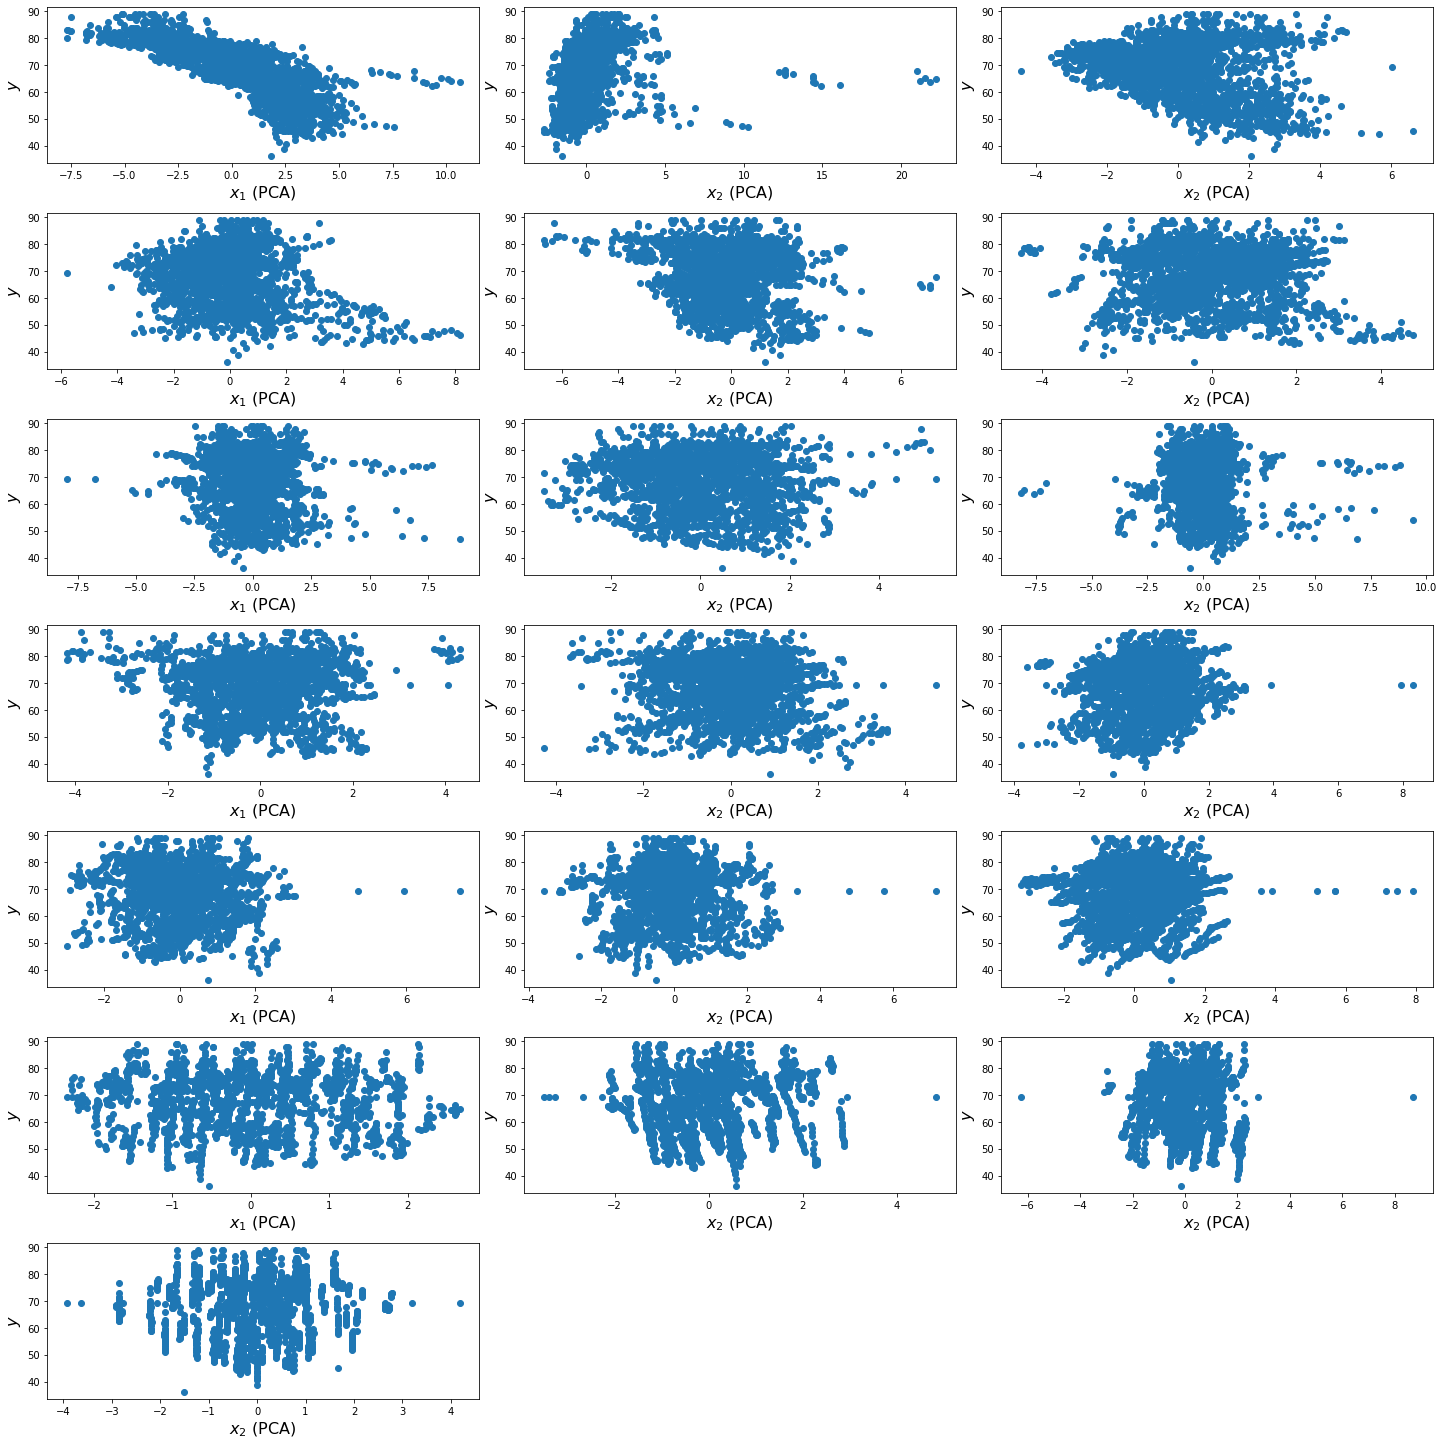

In [156]:
# Data visualization (15 components)
X_pca = PCA(n_components=19).fit_transform(X_scaled)


plt.figure(figsize=(20,20))
plt.subplot(7,3,1)
plt.scatter(X_pca[:,0],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,2)
plt.scatter(X_pca[:,1],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,3)
plt.scatter(X_pca[:,2],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,4)
plt.scatter(X_pca[:,3],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,5)
plt.scatter(X_pca[:,4],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,6)
plt.scatter(X_pca[:,5],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,7)
plt.scatter(X_pca[:,6],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,8)
plt.scatter(X_pca[:,7],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,9)
plt.scatter(X_pca[:,8],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)


plt.subplot(7,3,10)
plt.scatter(X_pca[:,9],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,11)
plt.scatter(X_pca[:,10],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,12)
plt.scatter(X_pca[:,11],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)


plt.subplot(7,3,13)
plt.scatter(X_pca[:,12],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,14)
plt.scatter(X_pca[:,13],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,15)
plt.scatter(X_pca[:,14],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,16)
plt.scatter(X_pca[:,15],y)
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,17)
plt.scatter(X_pca[:,16],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,18)
plt.scatter(X_pca[:,17],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(7,3,19)
plt.scatter(X_pca[:,18],y)
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### <span style="color: darkcyan">Section 3.3: Training </span> 
Next, in order to select a certain number of n_components, we will do a corresponding search of optimal hyperparameters.

In [4]:
from sklearn.model_selection import  GridSearchCV

<span style="background-color: lightblue">Section 3.3a: Split into training and test set + Scaling </span> 

In [157]:
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 211)
Test  data shape: (882, 211)


### Important :
#### GridSearch done by parts in order to represent each of the plots with its corresponding MSE variation in order to enhance interpretability.

<span style="background-color: lightblue">Section 3.3b: Maximum depth evaluation</span> 

{'max_depth': 13}

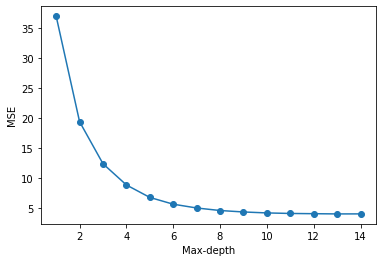

In [48]:
max_depth = range(1,15)
#min_samples_leaf = [1,5,10,15,50,100]
#n_estimators = [25,50,75,100,125,150]

param_grid = {
    'max_depth': max_depth,
    #'min_samples_leaf': min_samples_leaf
    #n_estimators = [25,50,75,100,125,150]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state = 1),
    param_grid = param_grid,
    cv = 4,
    scoring = 'neg_mean_squared_error'
    )
grid.fit(X_train_scaled, y_train)
#grid.best_score_ * -1

scores = grid.cv_results_['mean_test_score']
plt.plot(max_depth, scores*-1, '-o')
plt.xlabel('Max-depth')
plt.ylabel('MSE')

grid.best_params_

<span style="background-color: lightblue">Section 3.3c: Minimum samples per leaf evaluation</span> 

{'min_samples_leaf': 1}

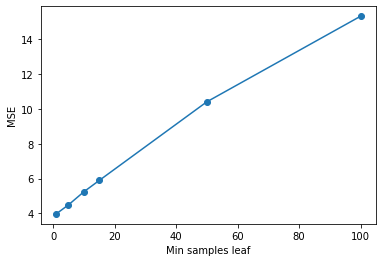

In [50]:
#max_depth = range(1,15)
min_samples_leaf = [1,5,10,15,50,100]
#n_estimators = [25,50,75,100,125,150]

param_grid = {
    #'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
    #n_estimators = [25,50,75,100,125,150]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state = 1),
    param_grid = param_grid,
    cv = 4,
    scoring = 'neg_mean_squared_error'
    )
grid.fit(X_train_scaled, y_train)
#grid.best_score_ * -1

scores = grid.cv_results_['mean_test_score']
plt.plot(min_samples_leaf, scores*-1, '-o')
plt.xlabel('Min samples leaf')
plt.ylabel('MSE')

grid.best_params_

<span style="background-color: lightblue">Section 3.3d: Number of estimators evaluation</span> 

{'n_estimators': 100}

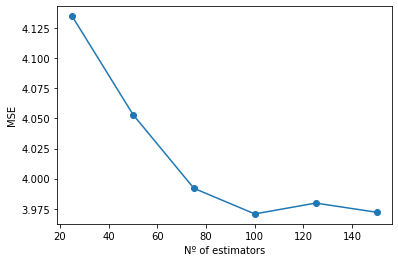

In [54]:
#max_depth = range(1,15)
#min_samples_leaf = [1,5,10,15,50,100]
n_estimators = [25,50,75,100,125,150]

param_grid = {
    #'max_depth': max_depth,
    #'min_samples_leaf': min_samples_leaf
     'n_estimators' : n_estimators
}

grid = GridSearchCV(
    RandomForestRegressor(random_state = 1),
    param_grid = param_grid,
    cv = 4,
    scoring = 'neg_mean_squared_error'
    )
grid.fit(X_train_scaled, y_train)
#grid.best_score_ * -1

scores = grid.cv_results_['mean_test_score']
plt.plot(n_estimators, scores*-1, '-o')
plt.xlabel('Nº of estimators')
plt.ylabel('MSE')

grid.best_params_

## Compare with test set

In [7]:
max_depth = range(1,15)
min_samples_leaf = [1,5,10,15,50,100]
n_estimators = [25,50,75,100,125,150]

param_grid = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'n_estimators' : n_estimators
}

grid = GridSearchCV(
    RandomForestRegressor(random_state = 1),
    param_grid = param_grid,
    cv = 4,
    scoring = 'neg_mean_squared_error'
    )
grid.fit(X_test_scaled, y_test)
#grid.best_score_ * -1

scores = grid.cv_results_['mean_test_score']

grid.best_params_

{'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 150}

{'n_estimators': 150}

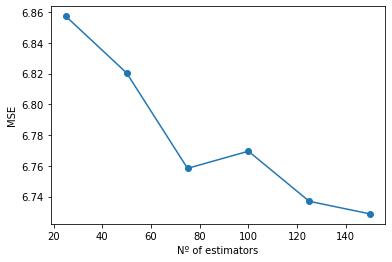

In [8]:
n_estimators = [25,50,75,100,125,150]

param_grid = {
     'n_estimators' : n_estimators
}

grid = GridSearchCV(
    RandomForestRegressor(random_state = 1),
    param_grid = param_grid,
    cv = 4,
    scoring = 'neg_mean_squared_error'
    )
grid.fit(X_test_scaled, y_test)

scores = grid.cv_results_['mean_test_score']
plt.plot(n_estimators, scores*-1, '-o')
plt.xlabel('Nº of estimators')
plt.ylabel('MSE')

grid.best_params_

### Justification of Hyperparameters train-test

Despite the difference between nº of estimators from grid search applying in the train and the test sets, by the high similarity from the others free parameters, we decide to choose the previous ones as we train our final model to the training set first and then predict from the test one. 

With respect to the parameter mentioned before (nº est), we will choose a value between both so no over fitting or lower chances of having it in the final result of both sets.

### <span style="color: darkcyan">Section 3.4: Performance evaluation </span> 

<span style="background-color: lightblue">Section 3.4.a: R^2 evaluation of PCA with all features</span> 

In [158]:
from sklearn.model_selection import train_test_split

X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 211)
Test  data shape: (882, 211)


In [159]:
X_pca_train = PCA(n_components=19).fit_transform(X_train_scaled)
Rf = RandomForestRegressor(n_estimators=125, max_depth=13, min_samples_leaf =1)
Rf.fit(X_pca_train, y_train)

RandomForestRegressor(max_depth=13)

In [160]:
X_pca_test = PCA(n_components=19).fit_transform(X_test_scaled)
predictions1 = Rf.predict(X_pca_test)
random_forestc = Rf.fit(X_pca_test, y_test)
# Calculate r-score 
r_score1 = random_forestc.score(X_pca_train, y_train)
print('R score training :',r_score1)
r_score1 = random_forestc.score(X_pca_test, y_test)
print('R score test :',r_score1)

R score training : 0.6286549360505205
R score test : 0.9819539741420341


<span style="background-color: lightblue">Section 3.4.b: R^2 evaluation of PCA with 19 features</span> 

In [161]:
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')

features = ['year','status','adult_mortality','alcohol','percentage_expenditure','hepatitis_b'
                ,'measles','bmi','under-five_deaths','polio' ,
               'total_expenditure','diphtheria','hiv/aids','gdp','population',
               'thinness_10-19_years', 'thinness_5-9_years', 'income_composition_of_resources', 
                'schooling']

X = X[features]
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

X_pca_train = PCA(n_components=19).fit_transform(X_train_scaled)
Rf = RandomForestRegressor(n_estimators=125, max_depth=13, min_samples_leaf =1)
Rf.fit(X_pca_train, y_train)

X_pca_test = PCA(n_components=19).fit_transform(X_test_scaled)
predictions2 = Rf.predict(X_pca_test)
random_forestc = Rf.fit(X_pca_test, y_test)
# Calculate r-score 
r_score2 = random_forestc.score(X_pca_train, y_train)
print('R score training:',r_score2)
r_score2 = random_forestc.score(X_pca_test, y_test)
print('R score test :',r_score2)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 19)
Test  data shape: (882, 19)
R score training: 0.7175542242589568
R score test : 0.9818955984557665


In [162]:
print('R score with all features :',r_score1)
print('R score with 19 features:',r_score2)

R score with all features : 0.9819539741420341
R score with 19 features: 0.9818955984557665


<span style="background-color: lightblue">Section 3.4.c: R^2 evaluation of the original model with all features</span> 

In [163]:
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Rf = RandomForestRegressor(n_estimators=125, max_depth=13, min_samples_leaf =1)
Rf.fit(X_train, y_train)

random_forestc = Rf.fit(X_test, y_test)
predictions3 = Rf.predict(X_test)
# Calculate r-score 
r_score3 = random_forestc.score(X_train, y_train)
print('R score training :',r_score3)
r_score3 = random_forestc.score(X_test, y_test)
print('R score test :',r_score3)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 211)
Test  data shape: (882, 211)
R score training : 0.9334844124167894
R score test : 0.9892595708648466


### Justification of 19 features example

At the beginning of this practice, we performed a visual analysis of the life expectancy data set. 

As in the first section of the lab assigment, we find out that the rest of the features, not included in the 19 from our list "features", were irrelevant or did not give much meaning to the performance of the exercise. 

There were a huge amount of features that actually provided information with respect each corresponding country given in the life expectancy data set. But, as a whole, they were of low importance to our model of random forest and so on.

In conclussion, we decided to drop them.

<span style="background-color: lightblue">Section 3.4d: R^2 evaluation of the original model with 19 features</span> 

In [164]:
X, y = load_life_expectancy('./data/Life_Expectancy_Data.csv')

features = ['year','status','adult_mortality','alcohol','percentage_expenditure','hepatitis_b'
                ,'measles','bmi','under-five_deaths','polio' ,
               'total_expenditure','diphtheria','hiv/aids','gdp','population',
               'thinness_10-19_years', 'thinness_5-9_years', 'income_composition_of_resources', 
                'schooling']

X = X[features]
feat_names = X.columns

# Separate in train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, 
                                                    random_state=0)

# scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train data shape:', X_train_scaled.shape)
print('Test  data shape:', X_test_scaled.shape)

Rf = RandomForestRegressor(n_estimators=125, max_depth=13, min_samples_leaf =1)
Rf.fit(X_train, y_train)

random_forestc = Rf.fit(X_test, y_test)
predictions4 = Rf.predict(X_test)
# Calculate r-score 
r_score4 = random_forestc.score(X_train, y_train)
print('R score training :',r_score4)
r_score4 = random_forestc.score(X_test, y_test)
print('R score test :',r_score4)

Predictors:  (2938, 211)
Target:  (2938,)
Train data shape: (2056, 19)
Test  data shape: (882, 19)
R score training : 0.9332372340596105
R score test : 0.9898677373193582


In [165]:
print('R score with all features PCA :',r_score1)
print('R score with 19 features PCA :',r_score2)
print('R score with all features :',r_score3)
print('R score with 19 features :',r_score4)

R score with all features PCA : 0.9819539741420341
R score with 19 features PCA : 0.9818955984557665
R score with all features : 0.9892595708648466
R score with 19 features : 0.9898677373193582


In [166]:
from sklearn import metrics

print('Mean Absolute Error with all features PCA :', metrics.mean_absolute_error(y_test, predictions1))
print('Mean Squared Error with all features PCA :', metrics.mean_squared_error(y_test, predictions1))
print('Root Mean Squared Error with all features PCA :', 
      np.sqrt(metrics.mean_squared_error(y_test, predictions1)))
print('')
print('Mean Absolute Error with 19 features PCA :', metrics.mean_absolute_error(y_test, predictions2))
print('Mean Squared Error with 19 features PCA :', metrics.mean_squared_error(y_test, predictions2))
print('Root Mean Squared Error with 19 features PCA :', 
      np.sqrt(metrics.mean_squared_error(y_test, predictions2)))

print('')
print('Mean Absolute Error with all features :', metrics.mean_absolute_error(y_test, predictions3))
print('Mean Squared Error with all features :', metrics.mean_squared_error(y_test, predictions3))
print('Root Mean Squared Error with all features :', 
      np.sqrt(metrics.mean_squared_error(y_test, predictions3)))

print('')
print('Mean Absolute Error with 19 features :', metrics.mean_absolute_error(y_test, predictions4))
print('Mean Squared Error with 19 features :', metrics.mean_squared_error(y_test, predictions4))
print('Root Mean Squared Error with 19 features :', 
      np.sqrt(metrics.mean_squared_error(y_test, predictions4)))

Mean Absolute Error with all features PCA : 4.193808789663489
Mean Squared Error with all features PCA : 30.60609489904137
Root Mean Squared Error with all features PCA : 5.532277550795999

Mean Absolute Error with 19 features PCA : 3.545956009756475
Mean Squared Error with 19 features PCA : 22.263226732533898
Root Mean Squared Error with 19 features PCA : 4.71839238857197

Mean Absolute Error with all features : 0.6820659404974004
Mean Squared Error with all features : 0.9583915203606331
Root Mean Squared Error with all features : 0.978974729173656

Mean Absolute Error with 19 features : 0.6513912346373814
Mean Squared Error with 19 features : 0.9041235236505218
Root Mean Squared Error with 19 features : 0.9508541021894589


### <span style="color: darkcyan">Results obtained from the model performance evaluation </span> 

- <span style="background-color: lightblue">Comparison with respect to R^2 score: </span> 

Firstly, we compare $R^2$ score between PCA transformed variables and the original features of the model, taking into account that also we will evaluate the model by getting all the features or by only getting 19 features.

| Model assessed | $R^2$ score test | $R^2$ score training |
|---|---|---|
|Model with all features (PCA) | 0.9819 | 0.6286 | 
|Model with 19 features (PCA) | 0.9818 | 0.7175 | 
|Model with all features (original) | 0.9892 | 0.9334 | 
|Model with 19 features (original) | 0.9898 | 0.93232 | 

- <span style="background-color: lightblue">Comparison with respect to MAE, MSE and RMSE: </span>

Additionally, we also did use as performance metrics the following measures: 

1. MAE : Mean Absolute Error
2. MSE : Mean Squared Error
3. RMSE : Root Mean Squared Error

| Model assessed | Mean Absolute Error | Mean Squared Error | Root Mean Squared Error |
|---|---|---|---|
|Model with all features (PCA) | 4.1938 | 30.6060 | 5.5322 |
|Model with 19 features (PCA) | 3.5459 | 22.2632 | 4.7183 |
|Model with all features (original) | 0.6820 | 0.9583 | 0.9789 |
|Model with 19 features (original) | 0.6513 | 0.9041 | 0.9508 |

<span style="background-color: lightblue">QUESTION 4:</span> 

4. Visualize the PCA transformation (use `n_components=2`) for the Pima Indian database, using a scatter plot. Colour your transformed samples according to the sample label (example [here](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py)). Is this transformation useful for classification? Justify your answer in terms of performance and interpretability.

## <span style="color:darkcyan"> Answer to question 4:  </span>

In [18]:
from src.ddbb import load_pima_indian
X, y = load_pima_indian('./data/pima_indian_diabetes.csv')

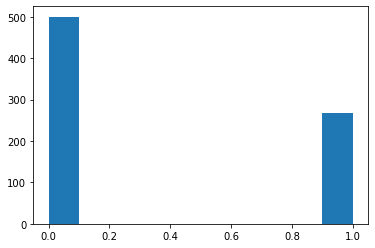

In [19]:
histogram = plt.hist(y.values)

In [20]:
from sklearn.decomposition import PCA

X = X.values
y = y.values

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

Explained variance ratio (first two components): [0.86510267 0.0891348 ]


In [37]:
y_0 =[]
y_1 =[]
for i in y:
    if i == 0:
        y_0.append(i)
    if i == 1:
        y_1.append(i)
print(len(y_0),len(y_1))

500 268


In [46]:
print(X_r[y == 0, 0].shape)
print(X_r[y == 0, 1].shape)
print(X_r[y == 1, 0].shape)
print(X_r[y == 1, 1].shape)

(500,)
(500,)
(268,)
(268,)


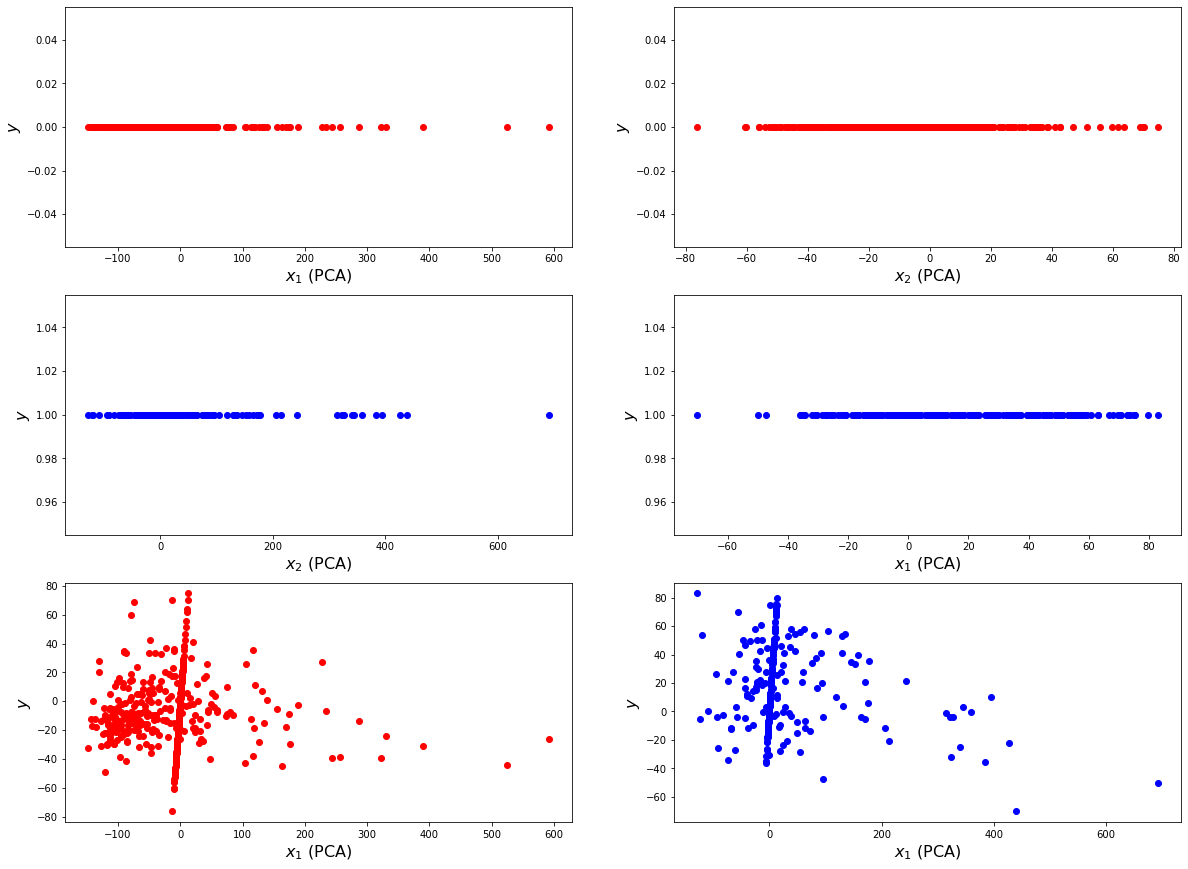

In [50]:
# Data visualization (just 2 components)
plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
plt.scatter(X_r[y == 0, 0],y_0, color = 'red')
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(3,2,2)
plt.scatter(X_r[y == 0, 1],y_0 ,color = 'red')
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(3,2,3)
plt.scatter(X_r[y == 1, 0],y_1 ,color = 'blue')
plt.xlabel('$x_2$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(3,2,4)
plt.scatter(X_r[y == 1, 1],y_1, color = 'blue')
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(3,2,5)
plt.scatter(X_r[y == 0, 0],X_r[y == 0, 1], color = 'red')
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)

plt.subplot(3,2,6)
plt.scatter(X_r[y == 1, 0],X_r[y == 1, 1], color = 'blue')
plt.xlabel('$x_1$ (PCA)',fontsize=16)
plt.ylabel('$y$',fontsize=16)


plt.show()

Text(0.5, 1.0, 'PCA of IRIS dataset')

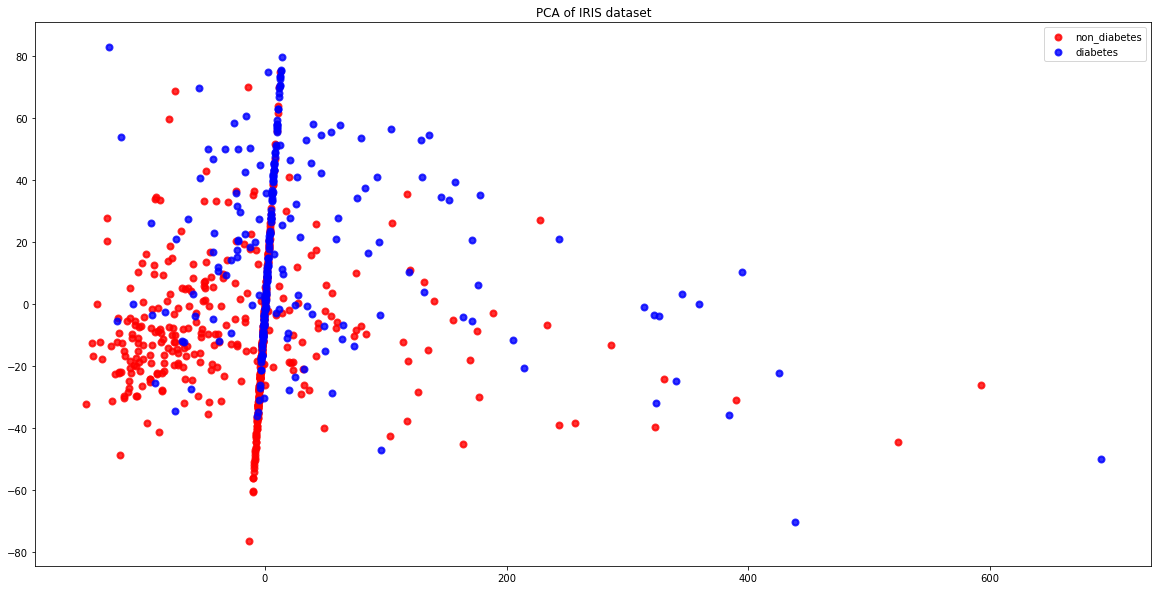

In [21]:
plt.figure(figsize=(20, 10))
colors = ['red', 'blue']
target_names = ['non_diabetes','diabetes']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=2,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

### Justification of answer 4

After looking to the explained variance ration and see the graphs plotted previously, we kind see which is the real goal of this algorithm: Decreasing the dimensionality of the data set and improving the interpretability by reducing the information loss.

The algorithm was made to eliminate the redundancy that some features might contribute to the dataframe, and then apply optimal classification tools in order to predict to which label the inputs belong to. 